### Introduction

Making a disease diagnosis from a sample of tissue (Pathology) is part art/part science. It relies on quantitative metrics such as counts of scores of miss-formed cell morphology, but also on a final subjective decision by the physician. This decision may or may not be formed from a objective weighting of the quantitative metrics. To gain insight into this decision, I anylized data from the wisconsin breast cancer database and compared the conclusions of the pathologist with the results of machine learning algorithims: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original). By inspecting the feature space, and visually comparing this to the diagnosis labels, I found that the pathological assessment appears to be formed from a roughly linear combination of the recorded cytological features. To test this I built a machine learning classifier and compared its performance to the results of the pathologist. The accuracy, precision and recall of this the logistic model were all very high. To gain further insight I identify the misclassified data and suggest they be re-inspected by the pathologist to determine the traits that distinguish them.

### Downloading and injesting the data.

For this I simply read in the data into a pandas dataframe. I labeled the columns using the description provided online.

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data

--2018-07-28 12:14:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19889 (19K) [text/plain]
Saving to: ‘breast-cancer-wisconsin.data.3’

breast-cancer-wisco 100%[===================>]  19.42K  --.-KB/s    in 0.04s   

2018-07-28 12:14:10 (433 KB/s) - ‘breast-cancer-wisconsin.data.3’ saved [19889/19889]



Attribute Information:

1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import sklearn

In [3]:
%matplotlib inline

In [4]:
names = ['samp_id','Clump_Thickness',
         'Cell_Size_Uniformity',
         'Cell_Shape_Uniformity',
         'Marginal_Adhesion',
         'Single_Epithelial',
         'Bare_Nuclei',
         'Bland_Chromatin',
         'Normal_Nucleoli',
         'Mitoses',
         'Class']

In [5]:
data = pd.read_csv('breast-cancer-wisconsin.data',names = names)

### Exploratory data analysis. 

First I'll take a quick look at the summary statistics. From this it looks like for all the predictors the data span the full range from 0 to 10. and the distributions are roughly similar.

In [6]:
data.describe()

,samp_id,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epithelial,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


There appears to be a question mark in the 'Bare_Nuclei' I'll write a quick function to fix that here.

In [7]:
fixit = []
for c in data.Bare_Nuclei:
    try:
        fixit.append(int(c))
    except ValueError:
        fixit.append(0)

In [8]:
data.Bare_Nuclei = fixit

Next I want to see if any of the data look like they are correlated, have other non-linear relationships or have strongly non-normal distributions. Since the number of features is relatively low, I think I should be able to visualize this in a scatter-matrix plot.

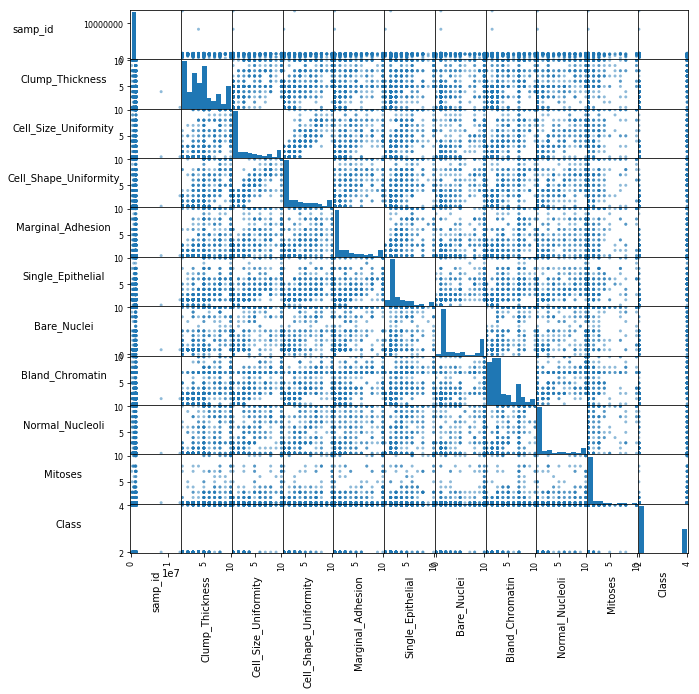

In [9]:
#fig = plt.figure(figsize = (20,20))
plts = pd.plotting.scatter_matrix(data,figsize = (10,10))

from matplotlib.artist import setp

for x in range(len(plts)):
    for y in range(len(plts)):
        # to get the axis of subplots
        ax = plts[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

It looks like there are a few pairwise correlations between a couple of features e.g. (Cell Size Uniformity and Cell Shape Uniformity). Most of the variables have a preponderance of '1s' but are otherwise rather evenly spread across the remaining 2-10 range. Since most feature scaling won't do anything to redistribute data out of the 1's bucket it's better to leave the data as is. The exception perhaps being 'Mitosis' that has a bit of a tail but most models should be fairly robust to this small amount of skew, so I'll proceed without rescaling the features. 

In [10]:
def make_features(data):
    """extract the features from the pandas dataframe 
    and convert it into a nxm matrix of m observations
    of n features. I am wrapping this in a function
    so to encapsulate my feature engineering here."""
    X =  np.vstack((data.Clump_Thickness,
                     data.Cell_Shape_Uniformity,
                     data.Marginal_Adhesion,
                     data.Single_Epithelial,
                     data.Bland_Chromatin,
                     data.Normal_Nucleoli,
                     data.Mitoses)).T
    return np.sqrt(X)

To evaluate what sort of modeling might be need it's worth first looking at a low dimentional projection of the data using PCA to see how the class I am predicting is distributed.

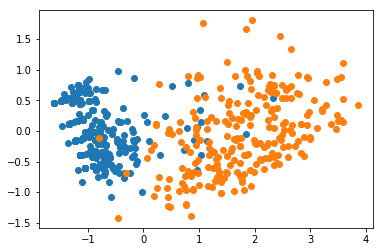

In [11]:
from sklearn.decomposition import PCA
X = make_features(data)
y = data.Class.values
pca = PCA()
pca.fit(X)
X_low = pca.transform(X)
plt.plot(X_low[:,0][y == 2],X_low[:,1][y == 2],'o')
plt.plot(X_low[:,0][y == 4],X_low[:,1][y == 4],'o')

### Modeling
It looks like a linear decision boundary should do a fairly good job. I will now approach this as a supervised machine learning problem to predict the class y from the data X, because the data look roughly linearly separable I'll start with a simple logistic regression model, though something like an SVM might also be useful.

In [12]:
X = make_features(data)
y = data.Class.values

In [13]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

Before training my model I'll grab a random sample of 30% of the data as a test set. Since the data set is small, but the decision boundary looks fairly simple I'm more concerned about evaluating the boundary with respect to false negatives and false positives than I am about having a very large training set since there are only a few features.

In [14]:
n = np.shape(X)[0]
rand_idxs = np.arange(0,n)
np.random.shuffle(rand_idxs)
train = rand_idxs[0:int(n*0.7)]
test = rand_idxs[int(n*0.7):]
X_train = X[train]
X_test = X[test]
y_train = y[train]
y_test = y[test]

I will now train a logistic regression model LogisticRegressionCV model using the balanced weighting to weight the data by the inverse of the class frequency. This model finds the best regularization parameter using 10-fold stratified cross validation to ensure that I'm not overfitting.

In [15]:
lr = LogisticRegressionCV(class_weight = 'balanced',penalty = 'l2')
lr.fit(X_train,y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

## Evaluation
I will now evaluate the model using a few of metrics. Importantly, I want to plot an ROC curve as a function of the probability threshold since this threshold can be used to tune the model to be biased to sensitivity vs recall.

First I'll simply look at the overall accuracy.

In [16]:
pred_test = lr.predict(X_test)
test_prob = lr.predict_proba(X_test)

In [17]:
sklearn.metrics.accuracy_score(y_test,pred_test)
#not bad

0.94285714285714284

There are a few other metrics to consider here. As we change the threshold of our classifier from one that is restrictive to one that is inclusive we increase our power to identify the actual positives as test positives, but we negatively impact two other metrics: 1) The type I error rate goes up (the actually negatives identified as positive), and the precision goes down (the fraction of tested positive that are actually positive) eventually reaching the incedence of positives within the population.

|  statistic             | conditional probability | TLA | critical value |formula    |
|------------------------|-------------------------|-----|----------------|-----------|
|Type I error rate       |P(t+&#124;-)             | FPR |     alpha      | FP/(TN+FP)|
|specificity             |P(t-&#124;-)             | SPC |    1-alpha     | TN/(TN+FP)|
|Type II error rate      |P(t-&#124;+)             | FNR |      beta      | FN/(TP+FN)|
|power/recall/sensitivity|P(t+&#124;+)             | TPR |     1-beta     | TP/(TP+FN)|
|------------------------|-------------------------|-----|----------------|-----------|
|precision               |P(+&#124;t+)             | PPV |                | TP/(TP+FP)|




First I'll plot an ROC curve and mark where the 0.5 threshold falls.

In [90]:
fpr,tpr,thresh = sklearn.metrics.roc_curve(y_test == 4,test_prob[:,0])

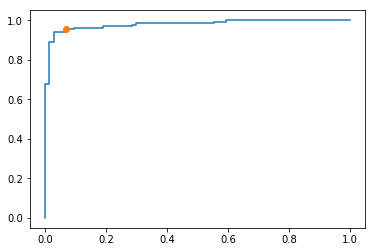

In [91]:
plt.plot(tpr,fpr)
t = np.argwhere(thresh >=0.5)[-1]
plt.plot(tpr[t],fpr[t],'o')

Now I'll look at precision vs recall(TPR)

In [98]:
precision,recall,thresh = sklearn.metrics.precision_recall_curve(y_test == 4,test_prob[:,1])

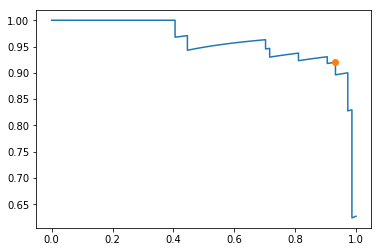

In [106]:
plt.plot(recall,precision)
plt.gca().set_ybound(0,1.1)
t = np.argwhere(thresh <=0.5)[-1]
plt.plot(recall[t],precision[t],'o')

Finally, to think about whether a high margin classifier might do better than simple logistic regression in this case I'll plot the data and see where the False Positives and False Negatives fall. I'll do this with the entire dataset since I want the pattern at the margins of the data clusters to be visually clear and I am not using this plot for optimization or to extract a validation metric. To help evaluate how the logistic regression fits into this space, I'll evaluate the model probabilities as a heat-map over the PC1 and PC2 space.

In [63]:
xx,yy = np.meshgrid(np.linspace(-4,4,50),np.linspace(-2.0,2.0,50))

In [64]:
grid = (xx.ravel(),yy.ravel())

In [65]:
pcx = np.dot(np.array(grid).T,pca.components_[:2,:])

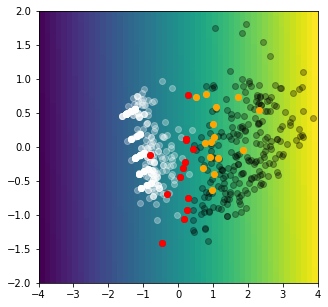

In [67]:
plt.figure(figsize = (5,5))
plt.imshow(lr.predict_proba(pcx+np.mean(X,axis = 0))[:,1].reshape(xx.shape),
          extent = (-4,4,-2.0,2.0),aspect = 'auto')
plt.plot(X_low[:,0][y == 2],X_low[:,1][y == 2],'o',alpha = 0.3,color = 'w')
plt.plot(X_low[:,0][y == 4],X_low[:,1][y == 4],'o',alpha = 0.3,color = 'k')
plt.plot(X_low[:,0][fp],X_low[:,1][fp],'o',color = 'r')
plt.plot(X_low[:,0][fn],X_low[:,1][fn],'o',color = 'orange')

From this, and an inspection of other dimensions, it appears that using a high margin linear classifier would be unlikely to improve performance over the logistic model. A non-linear classifier (such as a svm with a kernel trick) may work better, however given the smallish data set, I would be concerned about over-fitting.

A more usefull analysis is to report the sample id's of the misclassified data - perhaps the pathologist might take a look at these samples to see if there is anything special about them.

In [109]:
data.samp_id[fp]

12     1041801
58     1113483
101    1167439
146    1185609
179    1202812
222    1226012
247     145447
267     320675
272     320675
273     428903
326     752904
356     859164
455    1246562
489    1084139
Name: samp_id, dtype: int64

In [110]:
data.samp_id[fn]

1      1002945
3      1016277
40     1096800
148    1187457
196    1213375
232    1231706
252    1017023
259     242970
296     616240
315     704168
319     721482
352     846832
415    1239232
434    1293439
657    1333877
Name: samp_id, dtype: int64